In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from astropy.cosmology import FlatLambdaCDM
from tqdm import tqdm
from mass_assign import *
from grav_potential import *
from acceleration import *

cosmo = FlatLambdaCDM(H0=50, Om0=1)

In [18]:
# https://web.archive.org/web/20130217114132/http://t8web.lanl.gov/people/heitmann/test3.html
filename = '/Users/abry/data/Santa_Barbara/ic_sb128/particles_ic_sb128'
data = np.fromfile(filename, dtype=np.float32)
data = data.reshape(-1, 8)
par_df = pd.DataFrame(columns=['pos_x','vel_x','pos_y','vel_y','pos_z','vel_z','mass','id'], data=data)
ng=box_size = 128
# x[Mpc], v_x[km/s], y[Mpc], v_y[km/s], z[Mpc], v_z[km/s], particle mass[M_sol], particle tag
par_df.loc[:, ['vel_x','vel_y', 'vel_z']] = par_df.loc[:, ['vel_x','vel_y', 'vel_z']]*(u.km/u.s).to(u.Mpc/u.Gyr)
par_df.loc[:, ['pos_x','vel_x','pos_y','vel_y','pos_z','vel_z','mass']] = par_df.loc[:, ['pos_x','vel_x','pos_y','vel_y','pos_z','vel_z','mass']]*(ng/64)

(0.0, 128.0)

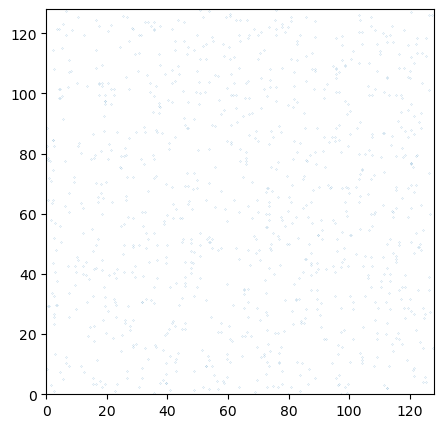

In [30]:
sample_num =1000
pars_info = par_df.loc[:,['pos_x', 'pos_y', 'pos_z', 'vel_x', 'vel_y', 'vel_z', 'mass']].sample(sample_num).values
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(pars_info[:, 0], pars_info[:, 1], s=0.01,)
ax.set_ylim(0, ng)
ax.set_xlim(0, ng)

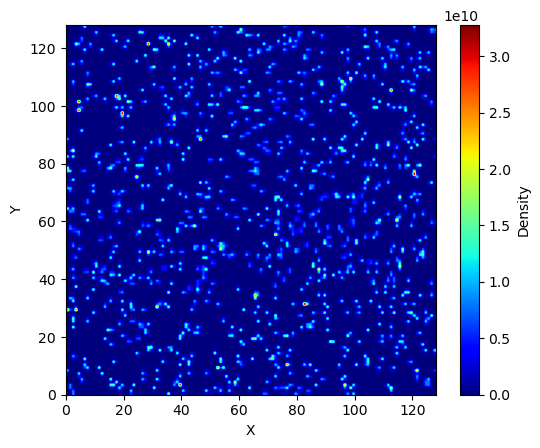

In [31]:
dens = cic_density_3d(pars_info[:,[0,1,2,6]], ng, h=1)
# Project density field along z-axis
dens_proj = np.sum(dens, axis=2)

# Visualize projected density field using Matplotlib
fig, ax = plt.subplots()
im = ax.imshow(dens_proj.T, cmap='jet',origin='lower', extent=[0, ng, 0, ng])
ax.set_xlabel('X')
ax.set_ylabel('Y')
cbar = fig.colorbar(im)
cbar.set_label('Density')
plt.show()

100%|██████████| 10/10 [00:04<00:00,  2.25it/s]
MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4

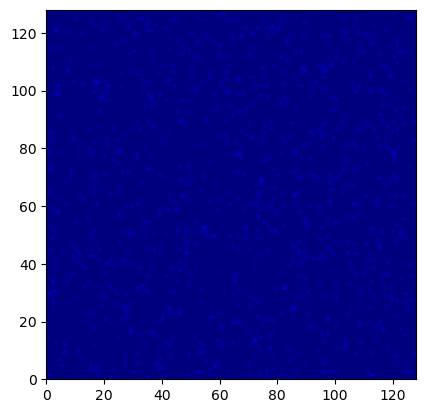

In [32]:
dt = 0.01

# fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# ax.set_ylim(0, ng)
# ax.set_xlim(0, ng)

img = [] # some array of images
frames = [] # for storing the generated images
fig, ax = plt.subplots()
# for step in tqdm(range((cosmo.lookback_time(63).to(u.Gyr).value/dt).astype(int))):
for step in tqdm(range(10)):

    pars_info[:, 0:3] = (pars_info[:, 0:3] + pars_info[:, 3:6] * 0.5 * dt) % ng # Fitrst step with Periodic boundary condition:

    dens = cic_density_3d(pars_info[:,[0,1,2,6]], ng, h=1)
    phi = grav_phi_3d(dens, h=1)
    acc_mesh_x, acc_mesh_y, acc_mesh_z = acc_mesh_3d(phi, h=1)
    acc_par_x, acc_par_y, acc_par_z = acc_par_3d(pars_info[:,[0,1,2]], acc_mesh_x, acc_mesh_y, acc_mesh_z, h=1)

    pars_info[:, 3:6] += np.array([acc_par_x, acc_par_y, acc_par_z]).T * dt # Second step:

    pars_info[:, 0:3] = (pars_info[:, 0:3] + pars_info[:, 3:6] * 0.5 * dt) % ng # Third step with Periodic boundary condition:

    dens_proj = np.sum(cic_density_3d(pars_info[:,[0,1,2,6]], ng, h=1), axis=2)
    frames.append([ax.imshow(dens_proj.T, cmap='jet',origin='lower', extent=[0, ng, 0, ng],animated=True, vmin=0, vmax=3.5e11)])
# ax.scatter(pars_info[:, 0], pars_info[:, 1], s=0.01,)
ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=1000)
ani.save('movie.mp4')


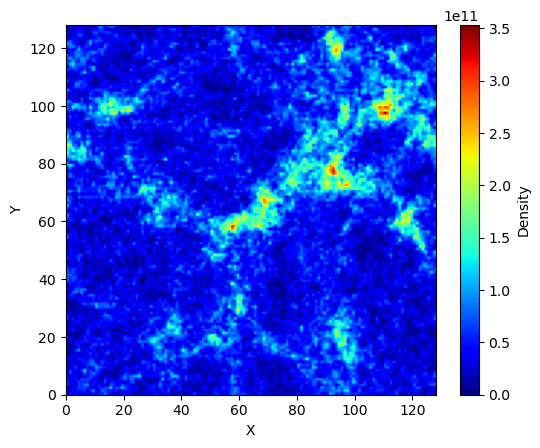

In [36]:
dens = cic_density_3d(pars_info[:,[0,1,2,6]], ng, h=1)
# Project density field along z-axis
dens_proj = np.sum(dens, axis=2)

# Visualize projected density field using Matplotlib
fig, ax = plt.subplots()
im = ax.imshow(dens_proj.T, cmap='jet',origin='lower', extent=[0, ng, 0, ng])
ax.set_xlabel('X')
ax.set_ylabel('Y')
cbar = fig.colorbar(im)
cbar.set_label('Density')
plt.show()

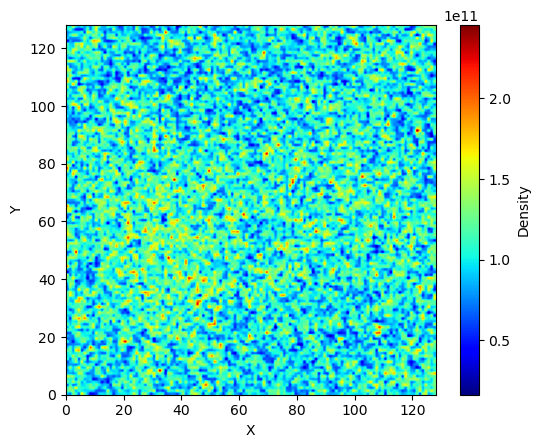

In [5]:
dens = cic_density_3d(pars_info[:,[0,1,2,6]], ng, h=1)
# Project density field along z-axis
dens_proj = np.sum(dens, axis=2)

# Visualize projected density field using Matplotlib
fig, ax = plt.subplots()
im = ax.imshow(dens_proj.T, cmap='jet',origin='lower', extent=[0, ng, 0, ng])
ax.set_xlabel('X')
ax.set_ylabel('Y')
cbar = fig.colorbar(im)
cbar.set_label('Density')
plt.show()

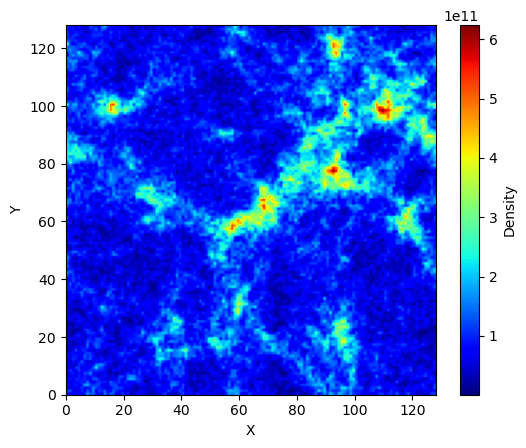

In [13]:
dens = cic_density_3d(pars_info[:,[0,1,2,6]], ng, h=1)
# Project density field along z-axis
dens_proj = np.sum(dens, axis=2)

# Visualize projected density field using Matplotlib
fig, ax = plt.subplots()
im = ax.imshow(dens_proj.T, cmap='jet',origin='lower', extent=[0, ng, 0, ng])
ax.set_xlabel('X')
ax.set_ylabel('Y')
cbar = fig.colorbar(im)
cbar.set_label('Density')
plt.show()

In [ ]:
32*u.Mpc